In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib.colors as colors, spectral.io.envi as envi, csv, cmocean
from netCDF4 import Dataset
from scipy.ndimage import morphology
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
from scipy.special import erf
from matplotlib.gridspec import GridSpec

plt.style.use('seaborn-paper')
%matplotlib inline

In [2]:
folder = '/Users/Zach/Google Drive/Research/PRISM/'
fontsize=14

In [4]:
def skew_normal_distribution(x,mode,sigma,amp,alpha):
    f = np.empty(shape=x.shape)
    f[x<mode] = np.exp(-(x[x<mode]-mode)**2/2/sigma**2/(1+alpha)**2)/np.sqrt(2*np.pi*sigma**2)
    f[x>=mode] = np.exp(-(x[x>=mode]-mode)**2/2/sigma**2/(1-alpha)**2)/np.sqrt(2*np.pi*sigma**2)
    return (f*amp)

def fit_curve(data, x=None, linear_fit_inds=None, allow_skew = False, best_guess = [683,25,1,0], bounds=None):
    d = data.copy()
    
    if np.any(np.isnan(d)):
        raise ValueError()
    
    if x is None:
        x = np.arange(len(data))
        
    if linear_fit_inds is not None:
        linfit_coeff = np.polyfit(x[linear_fit_inds],d[linear_fit_inds],1)
        d -= np.polyval(linfit_coeff,x)
        
    if allow_skew:
        func = skew_normal_distribution
        guess = best_guess[0:4]
    else:
        func = normal_distribution
        guess = best_guess[0:3]
        
    if bounds is None:
        fit,covar = curve_fit(func, x, d, p0=guess)
    else:
        fit,covar = curve_fit(func, x, d, p0=guess, bounds=bounds)

    if linear_fit_inds is not None:
        return fit,covar,linfit_coeff
    else:
        return fit,covar

In [5]:
nc = Dataset(folder+'prm20160118t163646.nc')
wl = nc.variables['wavelength'][:]
loc_filename = folder+'prm20160118t163646_rdn_v1k/prm20160118t163646_rdn_v1k_loc'
loc_file = envi.open(loc_filename+'.hdr', loc_filename)
loc = loc_file.read_bands(bands=[0,1]) # third band, Elevation, just gives 0's
loc_sm = np.nanmean(loc[0:6640][:,0:600].reshape(664,10,60,10,-1),axis=(1,3))


In [5]:
cloud_index = np.argmin(np.abs(wl-600));
cloud_threshold = 0.05
clouds = nc.variables['reflectance'][:,:,cloud_index]>cloud_threshold

In [6]:
FLH_bands = [633,683,733] # first two are for baseline, third is the maximum fluorescence signal
FLH_band_inds = np.array([np.argmin(np.abs(wl-band)) for band in FLH_bands])
baseline = np.mean(nc.variables['radiance'][:,:,[FLH_band_inds[0],FLH_band_inds[2]]],axis=2)
flh = nc.variables['radiance'][:,:,FLH_band_inds[1]]-baseline
baseline[morphology.binary_dilation(clouds,iterations=10)] = np.nan
flh[morphology.binary_dilation(clouds,iterations=10)] = np.nan
flh[flh==0] = np.nan

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


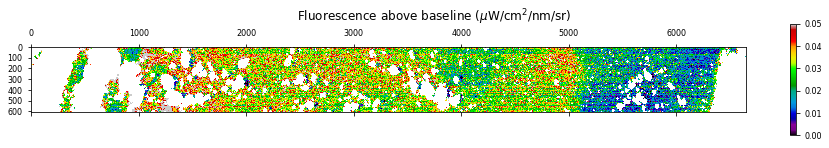

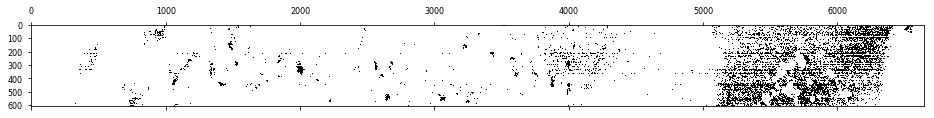

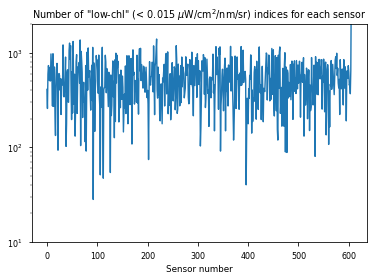

In [7]:
plt.matshow(flh.T,vmin=0,vmax=0.05,cmap=plt.cm.nipy_spectral); plt.colorbar(); plt.suptitle('Fluorescence above baseline ($\mu$W/cm$^2$/nm/sr)')
baseline_inds = np.abs(flh)<0.015
plt.matshow(baseline_inds.T,cmap=plt.cm.binary);
plt.figure()
plt.semilogy(np.sum(baseline_inds,axis=0))
plt.ylim([10,2000]); plt.xlabel('Sensor number')
plt.title('Number of "low-chl" (< 0.015 $\mu$W/cm$^2$/nm/sr) indices for each sensor');

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


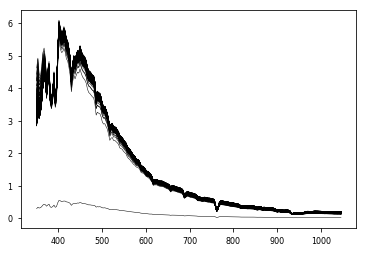

In [8]:
baseline_spectra = np.nan*np.empty(shape=(baseline_inds.shape[1],len(wl)))
for i in range(baseline_inds.shape[1]):
    baseline_spectra[i] = np.nanmedian(nc.variables['radiance'][baseline_inds[:,i],i],axis=0)
plt.plot(wl,baseline_spectra.T,color='k',lw=0.5);

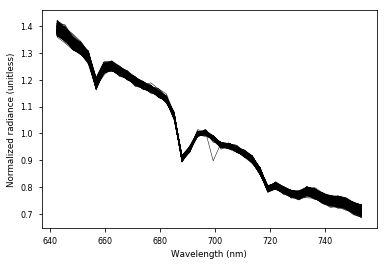

In [9]:
wl_fit_inds = np.logical_and(wl>640,wl<755)
wl_sm = wl[wl_fit_inds]
for i in range(baseline_spectra.shape[0]):
    baseline_spectra[i] /= np.mean(baseline_spectra[i][wl_fit_inds])
plt.plot(wl_sm,baseline_spectra.T[wl_fit_inds],color='k',lw=0.5);
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized radiance (unitless)');

In [8]:
flightpath = np.zeros(shape=loc_sm[:,:,0].shape); flightpath[[0,-1],:] = 1; flightpath[:,[0,-1]] = 1;


In [10]:
clouds_sm = np.nanmean(clouds[0:6640][:,0:600].reshape(664,10,60,10,-1),axis=(1,3))


In [11]:
data  = nc.variables['radiance'][:,:,wl_fit_inds]
data[morphology.binary_dilation(clouds,iterations=10)] = np.nan

In [12]:
# make new dataset
dataset = np.nan*np.empty(shape=data.shape)
for i in range(dataset.shape[1]):
    bs = baseline_spectra[i,wl_fit_inds]
    bs /= np.polyval(np.polyfit(wl_sm,bs,1),wl_sm)
    for j in range(dataset.shape[0]):
        if np.any(np.isnan(data[j,i])):
            continue
        bs_r = bs*np.polyval(np.polyfit(wl_sm,data[j,i],1),wl_sm)
        dataset[j,i] = data[j,i]/bs_r
dataset_sm = np.nanmean(dataset[0:6640][:,0:600].reshape(664,10,60,10,-1),axis=(1,3))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


In [125]:
fit_inds = np.logical_or(wl_sm<660,wl_sm>710)


In [14]:
import pickle
pickle.dump( dataset_sm, open( "dataset_sm.p", "wb" ) )

In [15]:
fit1,covar1,lin_coeffs1 = fit_curve(dataset[2200,500],x=wl_sm,linear_fit_inds=fit_inds,allow_skew=True, best_guess = [683,10.6,1,0],bounds=([600,0,0,-.5],[700,50,np.inf,1]))
print(fit1)
fit2,covar2,lin_coeffs2 = fit_curve(dataset_sm[220,50],x=wl_sm,linear_fit_inds=fit_inds,allow_skew=True, best_guess = [683,10.6,1,0],bounds=([600,0,0,-.5],[700,50,np.inf,1]))
print(fit2)

[ 6.78499855e+02  1.00419350e+01  5.63378900e-01 -4.02400823e-01]
[ 6.78589459e+02  1.05880258e+01  5.65165358e-01 -3.91449047e-01]


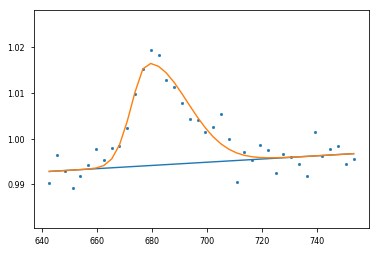

In [16]:
plt.scatter(wl_sm,dataset[2200,500],marker='.')
plt.plot(wl_sm,np.polyval(lin_coeffs1,wl_sm))
plt.plot(wl_sm,np.polyval(lin_coeffs1,wl_sm)+skew_normal_distribution(wl_sm,fit1[0],fit1[1],fit1[2],fit1[3]))

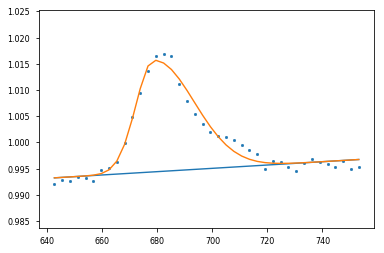

In [17]:
plt.scatter(wl_sm,dataset_sm[220,50],marker='.')
plt.plot(wl_sm,np.polyval(lin_coeffs2,wl_sm))
plt.plot(wl_sm,np.polyval(lin_coeffs2,wl_sm)+skew_normal_distribution(wl_sm,fit2[0],fit2[1],fit2[2],fit2[3]))

## Figure 1

In [18]:
MODIS_bands = np.array([[662,673,743],[672,683,753]])

In [123]:
ii = 2200; jj = 500;
II = 220; JJ = 50;

In [19]:

best_guess = wl_sm[np.argmax(dataset[ii,jj])]
fit1,covar1,lin_coeffs1 = fit_curve(dataset[ii,jj],x=wl_sm,linear_fit_inds=fit_inds,allow_skew=True, best_guess = [best_guess,10.6,0.1,0],bounds=([best_guess-5,5,0,-1],[best_guess+5,50,np.inf,1]))
av_err1 = np.sqrt(np.mean((dataset[ii,jj]-np.polyval(lin_coeffs1,x=wl_sm)-skew_normal_distribution(wl_sm,fit1[0],fit1[1],fit1[2],fit1[3]))**2))
print(fit1,av_err1)
best_guess = wl_sm[np.argmax(dataset_sm[II,JJ])]
fit2,covar2,lin_coeffs2 = fit_curve(dataset_sm[II,JJ],x=wl_sm,linear_fit_inds=fit_inds,allow_skew=True, best_guess = [best_guess,10.6,0.1,0],bounds=([best_guess-5,5,0,-1],[best_guess+5,50,np.inf,1]))
av_err2 = np.sqrt(np.mean((dataset_sm[II,JJ]-np.polyval(lin_coeffs2,x=wl_sm)-skew_normal_distribution(wl_sm,fit2[0],fit2[1],fit2[2],fit2[3]))**2))
print(fit2,av_err2)

[ 6.78499914e+02  1.00419760e+01  5.63380056e-01 -4.02393528e-01] 0.0026194285303804423
[ 6.78589449e+02  1.05880347e+01  5.65165597e-01 -3.91450090e-01] 0.0011918675555578288


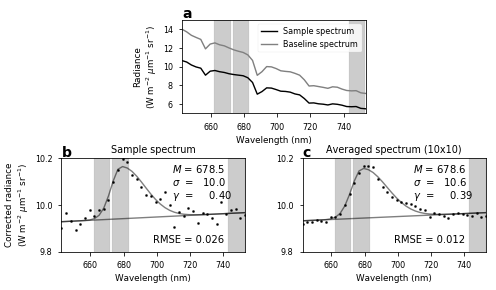

In [20]:
fs = 10;

plt.figure(figsize=(7,4))
gs = GridSpec(2,4)
ax1 = plt.subplot(gs[0,1:3]);
ax2 = plt.subplot(gs[1,0:2]);
ax3 = plt.subplot(gs[1,2::]);

ax1.plot(wl,nc.variables['radiance'][ii,jj,:]*10,color='k')
ax1.plot(wl,baseline_spectra[jj,:]*10,color='0.5')
ax1.legend(['Sample spectrum','Baseline spectrum'],loc='upper right')
 
ax2.set_title('Sample spectrum')
ax2.scatter(wl_sm,dataset[ii,jj]*10,s=5,color='k')
ax2.plot(wl_sm,np.polyval(lin_coeffs1,wl_sm)*10,color='k',alpha=0.5)
ax2.plot(wl_sm,np.polyval(lin_coeffs1,wl_sm)*10+skew_normal_distribution(wl_sm,fit1[0],fit1[1],fit1[2],fit1[3])*10,color='k',alpha=0.5)
ax2.text(.6,.85,r'$M$ = %.1f' % fit1[0],fontsize=fs,transform=ax2.transAxes)
ax2.text(.6,.71,r'$\sigma$  =   %.1f' % fit1[1],fontsize=fs,transform=ax2.transAxes)
ax2.text(.6,.57,r'$\gamma$  =     %.2f' % (-fit1[3]),fontsize=fs,transform=ax2.transAxes)
ax2.text(.5,.1,'RMSE = %.3f' % (av_err1*10),fontsize=fs,transform=ax2.transAxes)  
    
ax3.set_title('Averaged spectrum (10x10)')
ax3.scatter(wl_sm,dataset_sm[II,JJ]*10,s=5,color='k')
ax3.plot(wl_sm,np.polyval(lin_coeffs2,wl_sm)*10,color='k',alpha=0.5)
ax3.plot(wl_sm,np.polyval(lin_coeffs2,wl_sm)*10+skew_normal_distribution(wl_sm,fit2[0],fit2[1],fit2[2],fit2[3])*10,color='k',alpha=0.5)
ax3.text(.6,.85,r'$M$ = %.1f' % fit2[0],fontsize=fs,transform=ax3.transAxes)
ax3.text(.6,.71,r'$\sigma$  =   %.1f' % fit2[1],fontsize=fs,transform=ax3.transAxes)
ax3.text(.6,.57,r'$\gamma$  =     %.2f' % (-fit2[3]),fontsize=fs,transform=ax3.transAxes)
ax3.text(.5,.1,'RMSE = %.3f' % (av_err2*10),fontsize=fs,transform=ax3.transAxes)

# make pretty
for ax in [ax1,ax2,ax3]:
    ax.set_xlim([wl_sm[0],wl_sm[-1]])
    ax.set_xlabel('Wavelength (nm)');
    for k in range(MODIS_bands.shape[1]):
        ax.fill_betweenx([0,100],MODIS_bands[0,[k,k]],MODIS_bands[1,[k,k]],alpha=0.2,color='k',edgecolor='w')
ax1.set_ylim([5,15]); ax1.set_ylabel('Radiance\n(W m$^{-2}$ $\mu$m$^{-1}$ sr$^{-1}$)'); ax1.set_yticks(np.arange(6,15,2))
for ax in [ax2,ax3]:
    ax.set_ylim([9.8,10.2]);
    ax.set_yticks(np.arange(9.8,10.25,.2))
    ax.set_yticklabels(['9.8','10.0','10.2'])
ax2.set_ylabel('Corrected radiance\n(W m$^{-2}$ $\mu$m$^{-1}$ sr$^{-1}$)')


plt.tight_layout()

ax1.text(0,1.02,'a',fontsize=fontsize,fontweight='bold',transform=ax1.transAxes)
ax2.text(0,1.02,'b',fontsize=fontsize,fontweight='bold',transform=ax2.transAxes)
ax3.text(0,1.02,'c',fontsize=fontsize,fontweight='bold',transform=ax3.transAxes)

plt.tight_layout(h_pad=0)
plt.savefig('Fig1',dpi=300)

In [21]:
fits = np.nan*np.empty(shape=(dataset_sm.shape[0],dataset_sm.shape[1],4))
covars = np.nan*np.empty(shape=(dataset_sm.shape[0],dataset_sm.shape[1],4,4))
linfits = np.nan*np.empty(shape=(dataset_sm.shape[0],dataset_sm.shape[1],2))
sqerr = np.nan*np.empty(shape=(dataset_sm.shape[0],dataset_sm.shape[1]))
for i in range(dataset_sm.shape[0]):
    if np.mod(i,10)==0:
        print(i,end='')
    else:
        print('.',end='')
    for j in range(dataset_sm.shape[1]):
        if np.any(np.isnan(dataset_sm[i,j])):
            continue
        try:
            best_guess = wl_sm[np.argmax(dataset_sm[i,j])]
            fit,covar,linfit = fit_curve(dataset_sm[i,j],x=wl_sm,linear_fit_inds=fit_inds,allow_skew=True, best_guess = [best_guess,10.6,0.1,0],bounds=([best_guess-10,5,0,-1],[best_guess+10,50,np.inf,1]))
            fits[i,j] = fit
            covars[i,j] = covar
            linfits[i,j] = linfit
            sqerr[i,j] = np.sum((dataset_sm[i,j]-np.polyval(linfit,wl_sm)-skew_normal_distribution(wl_sm,fit[0],fit[1],fit[2],fit[3]))**2)/len(wl_sm)
        except RuntimeError:
            print('(Runtime error for %d)' % j, end=' ')
            continue;

0(Runtime error for 13) (Runtime error for 16) (Runtime error for 17) (Runtime error for 30) (Runtime error for 31) .........10.........20.........30.........40.........50.........60.........70.........80.........90.........100........(Runtime error for 39) (Runtime error for 40) .110.........120.........130.........140.........150.........160.........170.........180.........190.........200.........210.........220.........230.........240.........250.........260.........270.........280.........290.........300.........310.........320.........330.........340.........350.........360.........370.........380.........390.........400.(Runtime error for 46) ........410.........420.........430.........440.........450.........460.........470.........480.........490.........500.........510.........520.........530.........540.........(Runtime error for 56) 550.........(Runtime error for 50) 560....(Runtime error for 31) .(Runtime error for 52) ....(Runtime error for 44) (Runtime error for 46) 570(R

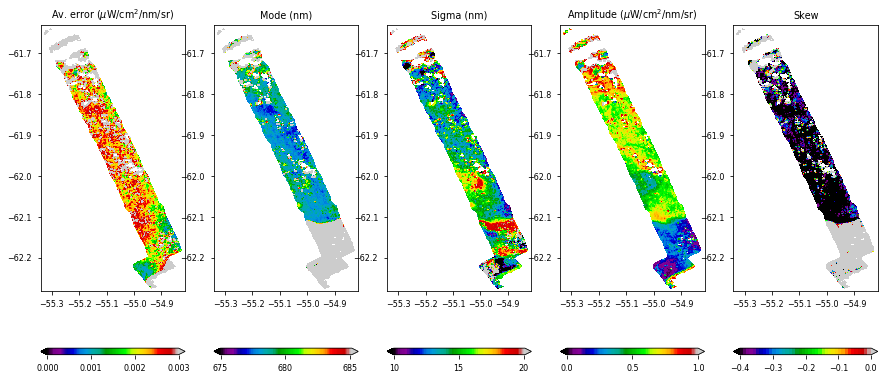

In [22]:
plt.figure(figsize=(15,7))
plt.subplot(151); plt.title('Av. error ($\mu$W/cm$^2$/nm/sr)');
plt.contourf(loc_sm[:,:,0],loc_sm[:,:,1],np.sqrt(sqerr[:,:]),levels=np.arange(0,3.01e-3,1e-5),extend='both',cmap=plt.cm.nipy_spectral)
plt.colorbar(orientation='horizontal',ticks=np.arange(0,3.1e-3,1e-3))
plt.subplot(152); plt.title('Mode (nm)')
plt.contourf(loc_sm[:,:,0],loc_sm[:,:,1],fits[:,:,0],levels=np.arange(675,685.1,.1),extend='both',cmap=plt.cm.nipy_spectral)
plt.colorbar(orientation='horizontal',ticks=np.arange(675,705,5))
plt.subplot(153); plt.title('Sigma (nm)')
plt.contourf(loc_sm[:,:,0],loc_sm[:,:,1],fits[:,:,1],levels=np.arange(10,20.1,.1),extend='both',cmap=plt.cm.nipy_spectral)
plt.colorbar(orientation='horizontal',ticks=np.arange(10,35,5))
plt.subplot(154); plt.title('Amplitude ($\mu$W/cm$^2$/nm/sr)')
plt.contourf(loc_sm[:,:,0],loc_sm[:,:,1],fits[:,:,2],levels=np.arange(0,1.01,0.01),extend='both',cmap=plt.cm.nipy_spectral)
plt.colorbar(orientation='horizontal',ticks=np.arange(0,1.01,0.5))
plt.subplot(155); plt.title('Skew')
plt.contourf(loc_sm[:,:,0],loc_sm[:,:,1],fits[:,:,3],levels=np.arange(-.4,0.01,.01),extend='both',cmap=plt.cm.nipy_spectral)
plt.colorbar(orientation='horizontal',ticks=np.arange(-.4,0.01,.1))

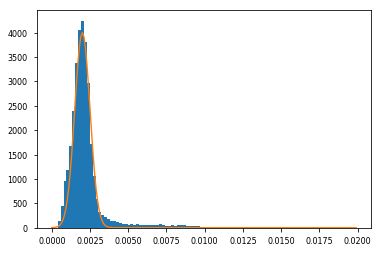

In [23]:
plt.hist(np.sqrt(sqerr[~np.isnan(sqerr)]),100);
plt.plot(np.arange(0,0.02,.0001),4000*np.exp(-(np.arange(0,0.02,.0001)-0.002)**2/2/.0005**2))

In [24]:
def chl_modis(wl,refl):
    sigma = 10/2.355
    s1 = np.trapz(refl*np.exp(-(wl-443)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),x=wl)
    s2 = np.trapz(refl*np.exp(-(wl-488)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),x=wl)
    s3 = np.trapz(refl*np.exp(-(wl-551)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),x=wl)
    a0 = 0.2424; a1 = -2.7423; a2 = 1.8017; a3 = 0.0015; a4 = -1.2280
    r = np.log10(np.max([s1,s2])/s3)
    return 10**(a0+a1*r+a2*r**2+a3*r**3+a4*r**4)
def chl_modis_Johnson_etal(wl,refl):
    sigma = 10/2.355
    s1 = np.trapz(refl*np.exp(-(wl-443)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),x=wl)
    s2 = np.trapz(refl*np.exp(-(wl-488)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),x=wl)
    s3 = np.trapz(refl*np.exp(-(wl-551)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),x=wl)
    a0 = 0.6994; a1 = -2.0384; a2 = -0.4656; a3 = 0.4337; a4 = 0
    r = np.log10(np.max([s1,s2])/s3)
    return 10**(a0+a1*r+a2*r**2+a3*r**3+a4*r**4)
def flh_modis(wl,rad): # in units of uW/cm^2/nm/sr (multiply by 10 to get W/m^2/um/sr)
    sigma = 10/2.355
    b1 = np.trapz(rad*np.exp(-(wl-667)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),x=wl)
    b2 = np.trapz(rad*np.exp(-(wl-748)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),x=wl)
    fl = np.trapz(rad*np.exp(-(wl-678)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),x=wl)
    return fl-np.interp(678,[667,748],[b1,b2]);
def flh_opt(wl,rad): # in units of uW/cm^2/nm/sr (multiply by 10 to get W/m^2/um/sr)
    sigma = 10/2.355
    b1 = np.trapz(rad*np.exp(-(wl-655)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),x=wl)
    b2 = np.trapz(rad*np.exp(-(wl-725)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),x=wl)
    fl = np.trapz(rad*np.exp(-(wl-683)**2/2/sigma**2)/np.sqrt(2*np.pi*sigma**2),x=wl)
    return fl-np.interp(683,[655,725],[b1,b2]);

In [25]:
chl_wl_inds = np.logical_and(wl>410,wl<590);
refl = nc.variables['reflectance'][:,:,chl_wl_inds]
refl_sm = np.mean(refl[0:6640][:,0:600].reshape(664,10,60,10,-1),axis=(1,3))
del refl
flh_wl_inds = np.logical_and(wl>630,wl<780);
rad = nc.variables['radiance'][:,:,flh_wl_inds]
rad_sm = np.mean(rad[0:6640][:,0:600].reshape(664,10,60,10,-1),axis=(1,3))
del rad

In [26]:
chl_sm = np.nan*np.empty(shape=refl_sm[:,:,0].shape)
flh_sm = np.nan*np.empty(shape=rad_sm[:,:,0].shape)
flh_opt_sm = np.nan*np.empty(shape=rad_sm[:,:,0].shape)
for i in range(dataset_sm.shape[0]):
    for j in range(dataset_sm.shape[1]):
        if clouds_sm[i,j,0] == 0:
            chl_sm[i,j] = chl_modis(wl[chl_wl_inds],refl_sm[i,j])
            flh_sm[i,j] = flh_modis(wl[flh_wl_inds],rad_sm[i,j])
            flh_opt_sm[i,j] = flh_opt(wl[flh_wl_inds],rad_sm[i,j])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


In [27]:
chl_Johnson_sm = np.nan*np.empty(shape=chl_sm.shape)
for i in range(dataset_sm.shape[0]):
    for j in range(dataset_sm.shape[1]):
        if clouds_sm[i,j,0] == 0:
            chl_Johnson_sm[i,j] = chl_modis_Johnson_etal(wl[chl_wl_inds],refl_sm[i,j])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


## Figure 2

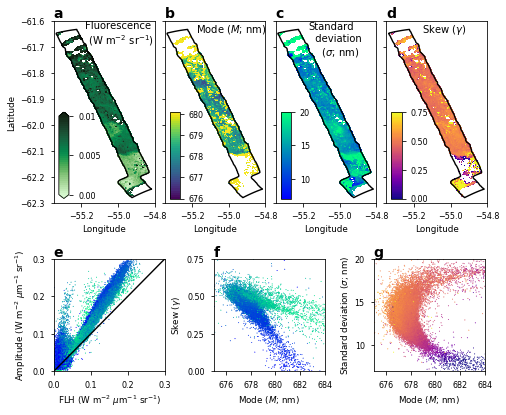

In [28]:
fs = 10;
plt.figure(figsize=(7,6))
ax1 = plt.axes([0.1,0.49,0.2,0.42]); cax1 = plt.axes([0.11,0.5,0.02,0.2]);
ax2 = plt.axes([0.32,0.49,0.2,0.42]); cax2 = plt.axes([0.33,0.5,0.02,0.2]);
ax3 = plt.axes([0.54,0.49,0.2,0.42]); cax3 = plt.axes([0.55,0.5,0.02,0.2]);
ax4 = plt.axes([0.76,0.49,0.2,0.42]); cax4 = plt.axes([0.77,0.5,0.02,0.2]);
ax5 = plt.axes([0.1,0.1,0.22,0.26]);
ax6 = plt.axes([0.4175,0.1,0.22,0.26]);
ax7 = plt.axes([0.735,0.1,0.22,0.26]);

im1 = ax1.contourf(loc_sm[:,:,0],loc_sm[:,:,1],fits[:,:,2]/100,levels=np.arange(0,.0101,.00025),cmap=cmocean.cm.algae,extend='both'); 
im2 = ax2.contourf(loc_sm[:,:,0],loc_sm[:,:,1],fits[:,:,0],levels=np.arange(676,680.1,.1),cmap=plt.cm.viridis); 
im3 = ax3.contourf(loc_sm[:,:,0],loc_sm[:,:,1],fits[:,:,1],levels=np.arange(7,20.1,.1),cmap=plt.cm.winter); 
im4 = ax4.contourf(loc_sm[:,:,0],loc_sm[:,:,1],-fits[:,:,3],levels=np.arange(0,.76,.01),cmap=plt.cm.plasma); 
im5 = ax5.scatter(flh_sm.ravel()*10+0.05,(fits[:,:,2]/np.sqrt(2*np.pi*fits[:,:,1]**2)).ravel()*10,c=fits[:,:,1].ravel(),marker='.',s=2,vmin=7,vmax=20,cmap=plt.cm.winter);
im6 = ax6.scatter(fits[:,:,0].ravel(),-fits[:,:,3].ravel(),c=fits[:,:,1].ravel(),marker='.',s=2,vmin=7,vmax=20,cmap=plt.cm.winter);
im7 = ax7.scatter(fits[:,:,0].ravel(),fits[:,:,1].ravel(),c=-fits[:,:,3].ravel(),marker='.',s=2,vmin=0,vmax=0.75,cmap=plt.cm.plasma);

ax1.set_ylabel('Latitude');
for ax in [ax1,ax2,ax3,ax4]:
    ax.contour(loc_sm[:,:,0],loc_sm[:,:,1],flightpath,[0],colors='k',lw=1)
    ax.set_xlim([-55.35,-54.8]); ax.set_ylim([-62.3,-61.6])
    ax.set_xlabel('Longitude'); ax.set_xticks(np.arange(-55.2,-54.7,.2));
for ax in [ax2,ax3,ax4]:
    ax.set_yticklabels([])

ax1.text(0.31,0.87,'Fluorescence\n (W m$^{-2}$ sr$^{-1}$)',fontsize=fs,transform=ax1.transAxes);
ax2.text(0.31,0.94,r'Mode ($M$; nm)',fontsize=fs,transform=ax2.transAxes);
ax3.text(0.33,0.81,'Standard\n  deviation\n    ($\sigma$; nm)',fontsize=fs,transform=ax3.transAxes);
ax4.text(0.35,0.94,'Skew ($\gamma$)',fontsize=fs,transform=ax4.transAxes);
ax5.set_xlabel('FLH (W m$^{-2}$ $\mu$m$^{-1}$ sr$^{-1}$)'); ax5.set_ylabel('Amplitude (W m$^{-2}$ $\mu$m$^{-1}$ sr$^{-1}$)'); ax5.set_yticks(np.arange(0,0.31,.1));
ax6.set_xlabel(r'Mode ($M$; nm)'); ax6.set_ylabel('Skew ($\gamma$)'); ax6.set_xticks(np.arange(676,685,2)); ax6.set_yticks(np.arange(-.25,.76,.25))
ax7.set_xlabel(r'Mode ($M$; nm)'); ax7.set_ylabel('Standard deviation ($\sigma$; nm)'); ax7.set_xticks(np.arange(676,685,2)); ax7.set_yticks(np.arange(10,21,5))
ax5.set_xlim([0,0.3]); ax5.set_ylim([0,0.3]); ax5.plot([0,0.3],[0,0.3],color='k')
ax6.set_xlim([675,684]); ax6.set_ylim([0,0.75]);
ax7.set_xlim([675,684]); ax7.set_ylim([7,20]);

cbar1 = plt.colorbar(im1,cax=cax1,ticks=np.arange(0,0.0101,.005)); cbar1.set_ticklabels(['0.00','0.005','0.01'])
plt.colorbar(im2,cax=cax2,ticks=np.arange(676,681,1))
plt.colorbar(im3,cax=cax3,ticks=np.arange(10,21,5))
plt.colorbar(im4,cax=cax4,ticks=np.arange(0,.76,.25)) 

ax1.text(0,1.02,'a',fontsize=fontsize,fontweight='bold',transform=ax1.transAxes)
ax2.text(0,1.02,'b',fontsize=fontsize,fontweight='bold',transform=ax2.transAxes)
ax3.text(0,1.02,'c',fontsize=fontsize,fontweight='bold',transform=ax3.transAxes)
ax4.text(0,1.02,'d',fontsize=fontsize,fontweight='bold',transform=ax4.transAxes)
ax5.text(0,1.02,'e',fontsize=fontsize,fontweight='bold',transform=ax5.transAxes)
ax6.text(0,1.02,'f',fontsize=fontsize,fontweight='bold',transform=ax6.transAxes)
ax7.text(0,1.02,'g',fontsize=fontsize,fontweight='bold',transform=ax7.transAxes)

plt.savefig('Fig2',dpi=300);

Model

In [51]:
h = 6.626e-34*6.022e23; # J s/mol, from J s/molecule
c = 3e8*1e9; # nm/s, from m/s
sza = 66; # this is reasonable using https://www.esrl.noaa.gov/gmd/grad/solcalc/azel.html
lookangle = 0;
csza = np.cos(sza*np.pi/180)
cla = np.cos(lookangle*np.pi/180)

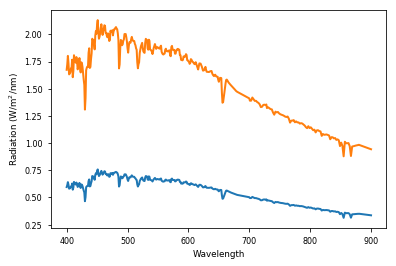

In [52]:
# load solar irradiance data
dat = np.loadtxt(folder+'gcirrad.dat')
dat = np.concatenate((dat[:,0:5],dat[:,5::]),axis=0)
o = np.argsort(dat[:,0])
dat = dat[o]
H0_wl = dat[:,0] # wavelengths of the data
H0 = (dat[:,1]*10) # W/m^2/nm
inds = np.logical_and(H0_wl>=400,H0_wl<=900) # only consider wavelengths from 400 to 900 nm
H0_wl = H0_wl[inds]
H0 = H0[inds]
# correct for Rayleigh transmission and add direct and diffuse components
Tr = np.exp(-((csza+0.15*(93.885-sza)**(-1.253))*(115.6406*H0_wl**4-1.335*H0_wl**2))**(-1));
rho_dsp = 0.0253*np.exp(0.0618*(sza-40));
E0 = H0*csza*(1-rho_dsp)*(Tr+(1-Tr**(0.95))/2)
plt.plot(H0_wl,E0,lw=2); plt.xlabel('Wavelength'); plt.ylabel('Radiation (W/m$^2$/nm)');
plt.plot(H0_wl,H0,lw=2);

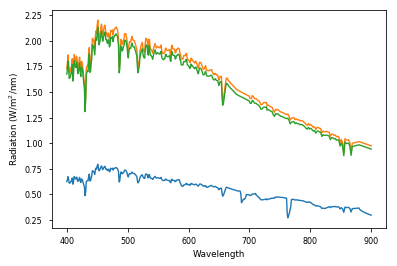

In [53]:
dat = np.loadtxt(folder+'gcirrad.dat')
dat = np.concatenate((dat[:,0:5],dat[:,5::]),axis=0)
o = np.argsort(dat[:,0])
dat = dat[o]
H0_wl = dat[:,0] # wavelengths of the data
H0 = (dat[:,1]*10) # W/m^2/nm
inds = np.logical_and(H0_wl>=400,H0_wl<=900) # only consider wavelengths from 400 to 900 nm
H0_wl = H0_wl[inds]
H0 = H0[inds]
aoz = dat[inds,2] # 1/cm
aw = dat[inds,4] # 1/cm
ao = dat[inds,3] # 1/cm

julianday = 18
MSLP = 99262 # Pa
W = np.sqrt(7.3**2+2.6**2) # m/s
Hoz = 0.0062/2.14*100 # cm, from kg/m^2 divided by kg/m^3
WV = 4.63/1000*100 # cm, from kg/m^2 divided by kg/m^3

F0 = H0*(1+0.0167*np.cos(2*np.pi*(julianday-3)/365))**2 # in W/m^2/nm
M = 1/(csza+0.15*(93.885-sza)**(-1.253)) # unitless
Moz = 1.0035/np.sqrt(csza**2+0.007) # unitless
Mprime = M*MSLP/101325 # unitless
Tr = np.exp(-Mprime/(115.6406*H0_wl**4-1.335*H0_wl**2)) # unitless
Ta = 1 # no aerosols
Tas = 1 # no aerosols
Taa = 1 # no aerosols
Fa = 0 # forward scattering probability -- not really used in any way because (1-Tas) = 0. If aerosols are added, should change this
Toz = np.exp(-aoz*Hoz*Moz) # unitless
To = np.exp(-1.41*ao*Mprime/((1+118.3*ao*M)**(0.45))) # unitless (note that somewhere in here is a unit of cm to cancel ao units)
Tw = np.exp(-0.2385*aw*WV*Mprime/((1+20.07*aw*WV*M)**(0.45))) # unitless
Ir = F0*csza*Toz*To*Tw*Taa*(1-Tr**0.95)/2 # W/m^2/nm
Ia = F0*csza*Toz*To*Tw*Taa*(Tr**1.5)*(1-Tas)*Fa # unitless (and 0)
rho_f = (4.5e-5*1.2e3*(0.49+0.065*W)*1e-3-4e-5)*W**2 # unitless assuming wind speed in m/s
b = -7.14e-4*W+0.0618 # unitless assuming wind speed in m/s
rho_dsp = 0.0253*np.exp(b*(sza-40)) # unitless
rho_ssp = 0.057 # unitless
rho_d = rho_dsp + rho_f # unitless
rho_s = rho_ssp + rho_f # unitless
Edd = F0*csza*Tr*Ta*Toz*To*Tw*(1-rho_d) # W/m^2/nm
Eds = (Ir+Ia)*(1-rho_s) # W/m^2/nm
E0 = Edd + Eds # W/m^2/nm

plt.plot(H0_wl,E0); plt.xlabel('Wavelength'); plt.ylabel('Radiation (W/m$^2$/nm)');
plt.plot(H0_wl,F0)
plt.plot(H0_wl,H0);

In [54]:
extinction_coeffs = ()
with open(folder+'Optipar_2016c.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)
    for row in csvreader:
        extinction_coeffs += (row,)
extinction_coeffs = np.concatenate(extinction_coeffs).reshape(len(extinction_coeffs),-1).astype('float64')
wl_measurements = extinction_coeffs[:,0]
inds = np.logical_and(wl_measurements>=400,wl_measurements<=900)
wl_measurements = wl_measurements[inds]
k_w = extinction_coeffs[inds,5]*100 # in units of 1/m
k_chl = extinction_coeffs[inds,2]/10 # in units of m^2/mg Chl (convert from cm^2/ug Chl)
fl = extinction_coeffs[inds,8] # in arbitrary units


In [55]:
fl_norm = fl/(np.trapz(wl_measurements*fl,x=wl_measurements)/(h*c))

In [56]:
PAR_inds = np.logical_and(wl_measurements>=400,wl_measurements<=700)
PAR_surf = np.trapz(wl_measurements[PAR_inds]*E0[PAR_inds],x=wl_measurements[PAR_inds])/h/c*1e6;
print('Surface PAR: %.1f uEin/m^2/s'%PAR_surf)

Surface PAR: 860.5 uEin/m^2/s


0.9999999999999999


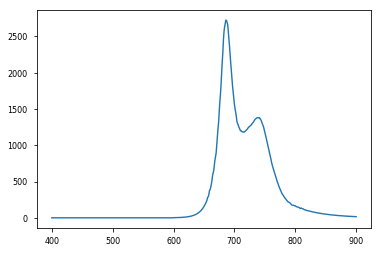

In [57]:
plt.plot(wl_measurements,fl_norm)
print(np.trapz(wl_measurements*fl_norm,x=wl_measurements)/(h*c));

In [58]:
def simple_forward_model(z,inputs,wl,compK=False):
    inputs[inputs<=0] = 1e-5
    chl = inputs[0]; fl_yield = inputs[1::]
    dz = np.diff(z);
    z_center = z[0:-1]+dz/2;
    Efl_outgoing = np.empty(shape=(len(dz),len(wl_measurements)));
    
    for i in range(len(z_center)):
        
        # amount of light that reaches this depth:
        Ed = E0*np.exp(-(k_w*z_center[i] + k_chl*np.sum(chl*z_center[i]))/csza); # W/m^2/nm
        PAR_inds = np.logical_and(wl_measurements>=400,wl_measurements<=700);
        PAR = np.trapz(wl_measurements[PAR_inds]*Ed[PAR_inds],x=wl_measurements[PAR_inds])/(h*c) # Ein/m^2/s
        Eabs = Ed*(1-np.exp(-k_chl*chl*dz[i]/csza)); # W/m^2/nm # amount absorbed by chlorophyll in this layer
        
        # amount of fluoescence that is emitted at this depth
        Nabs = np.trapz(wl_measurements*Eabs,x=wl_measurements)/(h*c); # Ein/m^2/s
        Nfl = fl_yield[i]*Nabs;#fluorescence_yield(PAR,qI[i])*Nabs; # Ein/m^2/s
        Efl = Nfl*fl_norm # W/m^2/nm
        
        # amount of fluorescence that makes it to the top
        Efl_outgoing[i] = Efl*np.exp(-(k_w*z_center[i] + k_chl*np.sum(chl*z_center[i]))/cla)/(4*np.pi); # W/m^2/nm/sr
    
    total_Efl_outgoing = np.sum(Efl_outgoing,axis=0)
    
    if compK: # compute Jacobian matrix K
        K = np.empty(shape=(inputs.size,wl.size))
        for i in range(inputs.size):
            dinputs = np.zeros(shape=inputs.shape)
            dinputs[i] = 1e-5;
            K[i] = (simple_forward_model(z,inputs+dinputs,wl)-applyInstrument(total_Efl_outgoing,wl_measurements,wl))/dinputs[i];
        return applyInstrument(total_Efl_outgoing,wl_measurements,wl),K.T
    else:
        return applyInstrument(total_Efl_outgoing,wl_measurements,wl)

def applyInstrument(F,w_meas,w_instr):
    spectral_res_fwhm = 3.5
    spectral_res_sigma = spectral_res_fwhm/2.355
    instru_res = w_instr[1]-w_instr[0]
    meas_res = w_meas[1]-w_meas[0]
    F2 = gaussian_filter1d(F, spectral_res_sigma/meas_res)
    finter = interp1d(w_meas, F2,kind='linear',bounds_error=False)
    return finter(w_instr)

In [59]:
dz = .25; # units of m
z = np.arange(0,10+dz/2,dz)
z_center = z[0:-1]+np.diff(z)/2

In [43]:
dz_fine = .01;
z_fine = np.arange(0,10+dz_fine/2,dz_fine)
z_center_fine = z_fine[0:-1]+np.diff(z_fine)/2

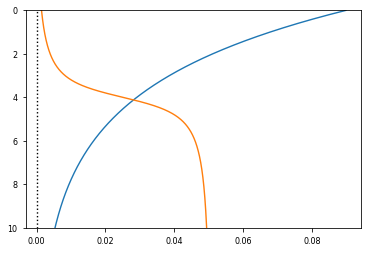

In [217]:
test_qI1 = 9*np.exp(-z_center_fine/3.55)/100 # units of mg/m^3
test_qI2 = np.arctan((z_center_fine-4)/2*np.pi)/60+.025
plt.plot(test_qI1,z_center_fine); plt.plot(test_qI2,z_center_fine); plt.ylim([10,0]);
plt.axvline(0,color='k',ls=':')

In [218]:
print(np.mean(test_qI1))
print(np.mean(test_qI2))

0.030039670058511044
0.02980823766036795


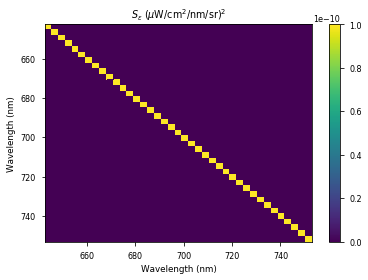

In [219]:
# set up measurement covariance matrix
noise = 1e-5 # W/m^2/nm/sr, from about 0.01 W/m^2/um/sr (from Figure 1b,c -- Figure 1b looks like noise if 0.1 W/m^2/um/sr)
invSe = np.zeros((len(wl_sm),len(wl_sm)))
for i in np.arange(0,len(wl_sm),1):
   invSe[i,i]=1./(noise**2) 
plt.pcolormesh(wl_sm,wl_sm,np.linalg.inv(invSe),cmap='viridis'); 
plt.colorbar(); 
plt.xlim(wl_sm[[0,-1]]); plt.ylim(wl_sm[[-1,0]])
plt.xlabel('Wavelength (nm)'); plt.ylabel('Wavelength (nm)'); plt.title('$S_\epsilon$ ($\mu$W/cm$^2$/nm/sr)$^2$');

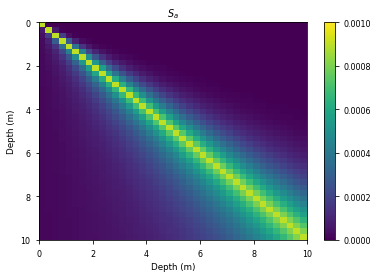

In [220]:
# set up prior covariance matrix
Sa = np.zeros((len(z),len(z)));
chl_surf = .75; # prior uncertainty in chlorophyll concentration (as a fraction)
Sa[0,0] = chl_surf**2 # will eventually need to be multiplied by the chl concentration squared
#zdiff_lengthscale = .5; # m; length scale over which one might expect qI to change
sigma_a  = .03; # prior uncertainty in quantum yield
for i in range(len(z_center)):
    for j in range(len(z_center)):
        Sa[i+1,j+1] = sigma_a**2*np.exp(-4*np.abs(i-j)*dz/z_center[i])
plt.pcolormesh(z,z,Sa[1::,1::],cmap='viridis',vmin=0,vmax=0.001); plt.colorbar(); 
plt.xlabel('Depth (m)'); plt.ylabel('Depth (m)'); plt.title('$S_a$'); plt.ylim([10,0]);

In [221]:
prior = .03*np.ones(shape=z_center.shape)
spectra = simple_forward_model(z_fine,np.concatenate((np.array([1]),test_qI1)),wl_sm);
spectra_prior,Ks = simple_forward_model(z,np.concatenate((np.array([1]),prior)),wl_sm,compK=True);

(10, 0)

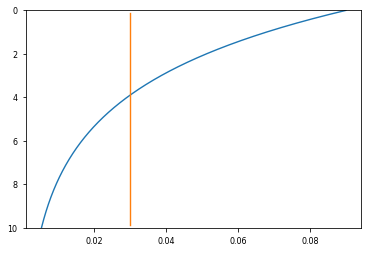

In [222]:
plt.plot(test_qI1,z_center_fine);
plt.plot(prior,z_center)
plt.ylim([10,0])

In [224]:
qI_profiles = (test_qI1,test_qI2,); # 0 values cause problems with the K matrix later on
qI_priors = [3*np.ones(shape=z_center.shape)/100 for q in qI_profiles]                
chl_val = np.array([1]);
priors = [np.concatenate((chl_val,q)) for q in qI_priors]
spectra = [[simple_forward_model(z_fine,np.concatenate((chl_val,q)),wl_sm)+np.random.randn(len(wl_sm))*noise for abcd in range(100)] for q in qI_profiles]
spectra_priors = [simple_forward_model(z,np.concatenate((chl_val,q)),wl_sm) for q in qI_priors]               
Ks = [simple_forward_model(z,np.concatenate((chl_val,q)),wl_sm,compK=True)[1] for q in qI_priors]        

qI_iteration1 = [[priors[i]+np.linalg.inv(np.linalg.inv(Sa)+Ks[i].T.dot(invSe).dot(Ks[i])).dot(Ks[i].T.dot(invSe).dot(spectra[i][j]-spectra_priors[i])) for j in range(100)] for i in range(len(qI_profiles))]
spectra_iteration1 = [[simple_forward_model(z,q[j],wl_sm) for j in range(100)] for q in qI_iteration1]


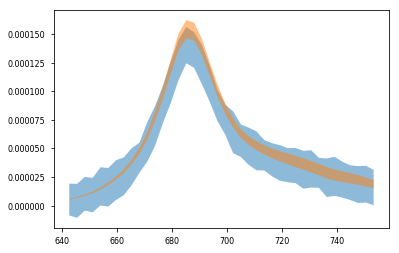

In [225]:
plt.fill_between(wl_sm,np.percentile(spectra[0],5,axis=0),np.percentile(spectra[0],95,axis=0),alpha=0.5)
plt.fill_between(wl_sm,np.percentile(spectra_iteration1[0],5,axis=0),np.percentile(spectra_iteration1[0],95,axis=0),alpha=0.5)

(10, 0)

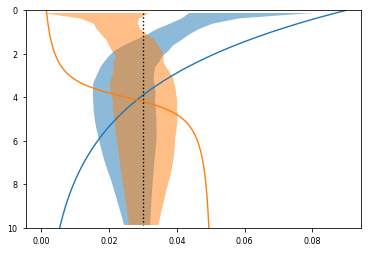

In [227]:
plt.plot(np.array(qI_profiles).T,z_center_fine);
plt.gca().set_prop_cycle(None)
#plt.plot(np.array(qI_priors).T,z_center,ls='-.')
plt.plot(qI_priors[0],z_center,ls=':',color='k')
plt.gca().set_prop_cycle(None)
for i in range(len(qI_iteration1)):
    plt.fill_betweenx(z_center,np.percentile(np.array(qI_iteration1[i]),5,axis=0)[1::],np.percentile(np.array(qI_iteration1[i]),95,axis=0)[1::],alpha=0.5,edgecolor=None);
plt.ylim([10,0])

In [48]:
max_iter = 10 # maximum number of iterations -- hopefully will never reach this point
dataset_sm_chl_profile = np.nan*np.empty(shape=(dataset_sm.shape[0],dataset_sm.shape[1],z_center.size))
num_iter = np.nan*np.empty(shape=(dataset_sm[:,:,0].shape))
dataset_sm_rmse = np.nan*np.empty(shape=(dataset_sm[:,:,0].shape))
for i in range(dataset_sm.shape[0]):
    if np.mod(i,10)==0:
        print(i,end='')
    else:
        print('.',end='')
    for j in range(dataset_sm.shape[1]):
        if np.any(np.isnan(dataset_sm[i,j])) or clouds_sm[i,j]>0:
            continue;
        spectrum_sm = dataset_sm[i,j].copy()/100 # units of W/m^2/nm/sr from uW/cm^2/ur
        fit = np.polyfit(wl_sm[fit_inds],spectrum_sm[fit_inds],1)
        spectrum_sm -= np.polyval(fit,wl_sm)
        chl_prior_sm = np.ones(shape=z_center.shape)*chl_sm[i,j]
        chl_iter = chl_prior_sm.copy()
        spectrum_iter,K_sm = simple_forward_model(z,chl_prior_sm,wl_sm,compK=True)
        rmse = np.sqrt(np.mean((spectrum_iter-spectrum_sm)**2))
        for k in range(max_iter):
            chl_new_iter = chl_prior_sm + np.linalg.inv(K_sm.T.dot(invSe).dot(K_sm)+np.linalg.inv(Sa*np.tile(chl_prior_sm**2,[len(z_center),1]))).dot(K_sm.T).dot(invSe).dot(spectrum_sm-spectrum_iter + K_sm.dot(chl_iter-chl_prior_sm))
            spectrum_iter,K_sm = simple_forward_model(z,chl_new_iter,wl_sm,compK=True)
            rmse_new = np.sqrt(np.mean((spectrum_iter-spectrum_sm)**2))
            if rmse<=rmse_new and k>0:
                num_iter[i,j] = k
                break
            else:
                chl_iter = chl_new_iter.copy()  
                rmse = rmse_new.copy()
        dataset_sm_chl_profile[i,j] = chl_iter
        dataset_sm_rmse[i,j] = rmse 

0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


.........10.........20.........30.........40.........50.........60.........70.........80.........90.........100.........110.........120.........130.........140.........150.........160.........170.........180.........190.........200.........210.........220.........230.........240.........250.........260.........270.........280.........290.........300.........310.........320.........330.........340.........350.........360.........370.........380.........390.........400.........410.........420.........430.........440.........450.........460.........470.........480.........490.........500.........510.........520.........530.........540.........550.........560.........570.........580.........590.........600.........610.........620.........630.........640.........650.........660...

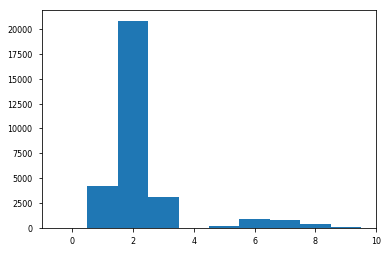

In [49]:
plt.hist(num_iter.ravel()[~np.isnan(num_iter.ravel())],np.arange(-0.5,10.5));

(10, 0)

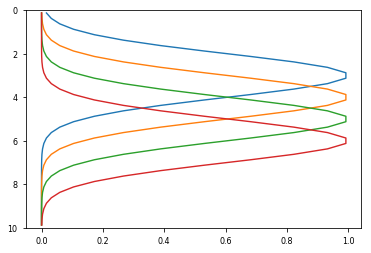

In [51]:
for i in [3,4,5,6]:
    p = np.exp(-(i-z_center)**2/2)
    plt.plot(p,z_center)
plt.ylim([10,0])

2 [ 6.85157421e+02  1.37628845e+01  1.73470886e-04 -9.86951679e-02]
4 [6.85720049e+02 1.24164006e+01 5.20178739e-05 8.94388210e-02]
6 [6.85805111e+02 1.20866901e+01 1.82456177e-05 2.01504016e-01]
8 [6.85734555e+02 1.21854108e+01 7.00555627e-06 2.70266894e-01]


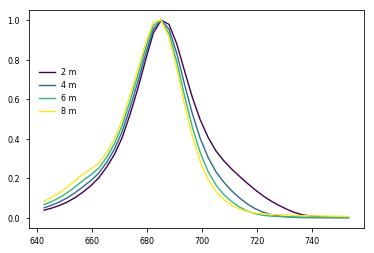

In [120]:
cmap = plt.cm.viridis
for i in [2,4,6,8]:
    p = .03*(np.abs(z_center-i)<.25)
    fm = simple_forward_model(z,np.concatenate((np.array([1]),p)),wl_sm);
    plt.plot(wl_sm,fm/np.max(fm),color=cmap((i-2)/6),label='%d m'%i)
    best_guess = wl_sm[np.argmax(fm)]
    print(i,fit_curve(fm,x=wl_sm,allow_skew=True,best_guess = [683,10.6,0.1,0])[0])
plt.legend(loc=(.02,.5),ncol=1,framealpha=0)


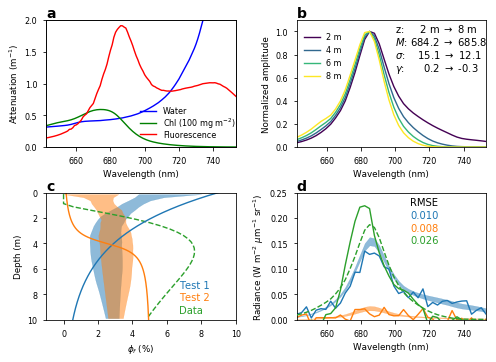

In [228]:
cmap = plt.cm.viridis
fs = 10;

plt.figure(figsize=(7,5))
ax1 = plt.subplot(221);
ax2 = plt.subplot(222);
ax3 = plt.subplot(223);
ax4 = plt.subplot(224);

l1, = ax1.plot(wl_measurements,k_w,color='b');
l2, = ax1.plot(wl_measurements,(k_chl*100),color='g');
ax1b = ax1.twinx();
l3, = ax1b.plot(wl_measurements,fl_norm,color='r');
ax1b.legend([l1,l2,l3],['Water',r'Chl (100 mg m$^{-2}$)','Fluorescence'],loc=(0.48,0.04),labelspacing=0,framealpha=0,edgecolor='none',columnspacing=0)

for i in [2,4,6,8]:
    p = np.exp(-(i-z_center)**2/2)
    fm = simple_forward_model(z,np.concatenate((np.array([1]),p)),wl_sm);
    ax2.plot(wl_sm,fm/np.max(fm),color=cmap((i-2)/6),label='%d m'%i)
    if i==2:
        fits_theoretical1 = fit_curve(fm,x=wl_sm,allow_skew=True,best_guess = [683,10.6,0.1,0])[0]
    elif i==8:
        fits_theoretical2 = fit_curve(fm,x=wl_sm,allow_skew=True,best_guess = [683,10.6,0.1,0])[0]
ax2.legend(loc=(.02,.5),ncol=1,framealpha=0)

ax3.fill_betweenx(z_center,np.percentile(np.array(qI_iteration1[0]),5,axis=0)[1::]*100,np.percentile(np.array(qI_iteration1[0]),95,axis=0)[1::]*100,alpha=0.5,edgecolor=None,color='C0');
ax3.fill_betweenx(z_center,np.percentile(np.array(qI_iteration1[1]),5,axis=0)[1::]*100,np.percentile(np.array(qI_iteration1[1]),95,axis=0)[1::]*100,alpha=0.5,edgecolor=None,color='C1');
ax3.plot(dataset_sm_qI_profile[II,JJ]*100,z_center,color='C2',ls='--')[0];
ax3.plot(qI_profiles[0]*100,z_center_fine,color='C0');
ax3.plot(qI_profiles[1]*100,z_center_fine,color='C1');

ax4.plot(wl_sm,spectra[0][0]*1000,color='C0')
ax4.plot(wl_sm,spectra[1][0]*1000,color='C1')
fit = np.polyfit(wl_sm[fit_inds],dataset_sm[II,JJ,fit_inds],1)
ax4.plot(wl_sm,dataset_sm[II,JJ]*10-np.polyval(fit,x=wl_sm)*10,zorder=20,color='C2')
ax4.plot(wl_sm,simple_forward_model(z,np.concatenate((dataset_sm_retrieved_chl[II,JJ,np.newaxis],dataset_sm_qI_profile[II,JJ])),wl_sm)*1000,color='C2',zorder=20,ls='--')
ax4.fill_between(wl_sm,np.percentile(spectra_iteration1[0],5,axis=0)*1000,np.percentile(spectra_iteration1[0],95,axis=0)*1000,alpha=0.5,edgecolor=None,color='C0');
ax4.fill_between(wl_sm,np.percentile(spectra_iteration1[1],5,axis=0)*1000,np.percentile(spectra_iteration1[1],95,axis=0)*1000,alpha=0.5,edgecolor=None,color='C1');

ax1.set_xlim(wl_sm[[0,-1]]); ax1.set_ylim([0,2]); ax1b.set_yticks([]);
ax2.set_xlim(wl_sm[[0,-1]]); ax2.set_ylim([0,1.1]);
ax3.set_xlim([-1,10]); ax3.set_ylim([10,0]);
ax4.set_xlim(wl_sm[[0,-1]]); ax4.set_ylim([0,.25]);
ax1.set_xlabel('Wavelength (nm)'); ax1.set_ylabel('Attenuation (m$^{-1}$)');
ax2.set_xlabel('Wavelength (nm)'); ax2.set_ylabel('Normalized amplitude');
ax3.set_xlabel('$\phi_f$ (%)'); ax3.set_ylabel('Depth (m)');
ax4.set_xlabel('Wavelength (nm)'); ax4.set_ylabel('Radiance (W m$^{-2}$ $\mu$m$^{-1}$ sr$^{-1}$)');

ax2.text(.52,.9,r'z:     2 m $\rightarrow$ 8 m',fontsize=fs,transform=ax2.transAxes)
ax2.text(.52,.8,r'$M$: %.1f $\rightarrow$ %.1f' % (fits_theoretical1[0],fits_theoretical2[0]),fontsize=fs,transform=ax2.transAxes)
ax2.text(.52,.7,r'$\sigma$:    %.1f $\rightarrow$ %.1f' % (fits_theoretical1[1],fits_theoretical2[1]),fontsize=fs,transform=ax2.transAxes)
ax2.text(.52,.6,r'$\gamma$:      %.1f $\rightarrow$ %.1f' % (-fits_theoretical1[3],-fits_theoretical2[3]),fontsize=fs,transform=ax2.transAxes)

ax3.text(0.7,0.25,'Test 1',color='C0',transform=ax3.transAxes,fontsize=fs)
ax3.text(0.7,0.15,'Test 2',color='C1',transform=ax3.transAxes,fontsize=fs)
ax3.text(0.7,0.05,'Data',color='C2',transform=ax3.transAxes,fontsize=fs)

ax4.text(0.6,0.9,'RMSE',color='k',transform=ax4.transAxes,fontsize=fs)
ax4.text(0.6,0.8,'%.3f' % (np.mean(np.sqrt((np.array(spectra[0])-np.array(spectra_iteration1[0]))**2))*1000),color='C0',transform=ax4.transAxes,fontsize=fs)
ax4.text(0.6,0.7,'%.3f' % (np.mean(np.sqrt((np.array(spectra[1])-np.array(spectra_iteration1[1]))**2))*1000),color='C1',transform=ax4.transAxes,fontsize=fs)
ax4.text(0.6,0.6,'%.3f' % (dataset_sm_rmse[II,JJ]*1000), color='C2',transform=ax4.transAxes,fontsize=fs)

ax1.text(0,1.02,'a',fontsize=fontsize,fontweight='bold',transform=ax1.transAxes)
ax2.text(0,1.02,'b',fontsize=fontsize,fontweight='bold',transform=ax2.transAxes)
ax3.text(0,1.02,'c',fontsize=fontsize,fontweight='bold',transform=ax3.transAxes)
ax4.text(0,1.02,'d',fontsize=fontsize,fontweight='bold',transform=ax4.transAxes)

plt.tight_layout()

plt.savefig('Fig3_edit',dpi=300);

In [54]:
S = np.linalg.inv(Ks[0].T.dot(invSe).dot(Ks[0])+np.linalg.inv(Sa))
Gain = S.dot(Ks[0].T).dot(invSe)
AK = Gain.dot(Ks[0])
AK_max_index = np.argmax(AK,axis=0)
AK_max = np.max(AK,axis=0);

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


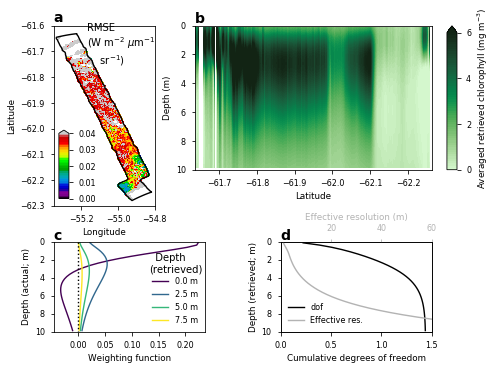

In [56]:
cmap = plt.cm.viridis
fs = 10;

plt.figure(figsize=(7,5))
ax1 = plt.axes([.1,.45,.2,.5]); 
ax2 = plt.axes([.38,.55,.47,.4]); 
ax3 = plt.axes([.1,.1,.3,.25]); 
ax4 = plt.axes([.55,.1,.3,.25]);
ax4b = ax4.twiny(); 
cax1 = plt.axes([.11,.47,.02,.19]); 
cax2 = plt.axes([.88,.55,.02,.4]);

im1 = ax1.contourf(loc_sm[:,:,0],loc_sm[:,:,1],dataset_sm_rmse*1000,levels=np.arange(0,0.041,.001),extend='max',cmap=plt.cm.nipy_spectral);
ax1.contour(loc_sm[:,:,0],loc_sm[:,:,1],flightpath,[0],colors='k',lw=1)

im2 = ax2.contourf(np.nanmean(loc_sm[:,:,1],axis=1),z_center,np.nanmean(dataset_sm_chl_profile,axis=1).T,levels=np.arange(0,6.01,.1),extend='max',cmap=cmocean.cm.algae);

inds = [np.argmin(np.abs(z_center-zz)) for zz in [0,2.5,5,7.5]]
for i in range(len(inds)):
    ax3.plot(AK[:,inds[i]],z_center,color=cmap(np.linspace(0,1,len(inds))[i]))
ax3.legend(['0.0 m','2.5 m','5.0 m','7.5 m'],loc='lower right',framealpha=0)
ax3.plot([0,0],[0,10],'k:')

l3, = ax4.plot(np.cumsum(np.diag(AK)),z_center,color='k')
l4, = ax4b.plot(.25/AK_max,z_center,color='0.7'); plt.ylim([10,0]); plt.xlim([0,50])
ax4b.legend([l3,l4],['dof','Effective res.'],loc='lower left',framealpha=0)

cbar1 = plt.colorbar(im1,cax=cax1,ticks=np.arange(0,0.041,.01))
cbar2 = plt.colorbar(im2,cax=cax2,label='Averaged retrieved chlorophyll (mg m$^{-3}$)',ticks=np.arange(0,6.1,2));

ax1.set_ylabel('Latitude'); ax1.set_xlabel('Longitude'); ax1.set_xlim([-55.35,-54.8]); ax1.set_ylim([-62.3,-61.6]); ax1.set_xticks(np.arange(-55.2,-54.7,.2))
ax2.set_xlabel('Latitude'); ax2.set_ylabel('Depth (m)'); ax2.set_ylim([10,0]); ax2.set_xlim(np.mean(loc_sm[:,:,1],axis=1)[[0,-1]]);
ax3.set_ylabel('Depth (actual; m)'); ax3.set_xlabel('Weighting function'); ax3.set_ylim([10,0]); 
ax4.set_xlabel('Cumulative degrees of freedom'); ax4.set_ylabel('Depth (retrieved; m)'); ax4.set_ylim([10,0]); ax4.set_xlim([0,1.5]); ax4.set_xticks(np.arange(0,1.6,.5))
ax4b.set_xlabel('Effective resolution (m)',color='0.7'); ax4b.tick_params(color='0.7', labelcolor='0.7'); ax4b.set_xlim([0,60]); ax4b.set_xticks(np.arange(20,61,20))

ax1.text(.33,.78,'RMSE\n(W m$^{-2}$ $\mu$m$^{-1}$\n    sr$^{-1}$)',fontsize=fs,transform=ax1.transAxes)
ax3.text(.63,.66,'  Depth\n(retrieved)',fontsize=fs,transform=ax3.transAxes)

ax1.text(0,1.02,'a',fontsize=fontsize,fontweight='bold',transform=ax1.transAxes)
ax2.text(0,1.02,'b',fontsize=fontsize,fontweight='bold',transform=ax2.transAxes)
ax3.text(0,1.02,'c',fontsize=fontsize,fontweight='bold',transform=ax3.transAxes)
ax4.text(0,1.02,'d',fontsize=fontsize,fontweight='bold',transform=ax4.transAxes)

plt.savefig('Fig4',dpi=300)

In [235]:
import pickle
wl_sm,dataset_sm,dataset_sm_rmse,num_iter,dataset_sm_qI_profile,chl_sm,dataset_sm_retrieved_chl,z_center,Ks,Sa,invSe = pickle.load(open(folder+'qI_fits_181012.p','rb'))


In [22]:
S = np.linalg.inv(Ks[:,1::].T.dot(invSe).dot(Ks[:,1::])+np.linalg.inv(Sa[1::,1::]))
Gain = S.dot(Ks[:,1::].T).dot(invSe)
AK = Gain.dot(Ks[:,1::])
AK_max_index = np.argmax(AK,axis=0)
AK_max = np.max(AK,axis=0);

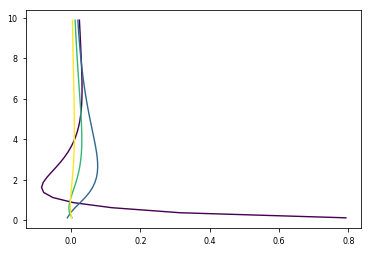

In [25]:
inds = [np.argmin(np.abs(z_center-zz)) for zz in [0,2.5,5,7.5]]
for i in range(len(inds)):
    plt.plot(AK[:,inds[i]],z_center,color=cmap(np.linspace(0,1,len(inds))[i]))
plt.x

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


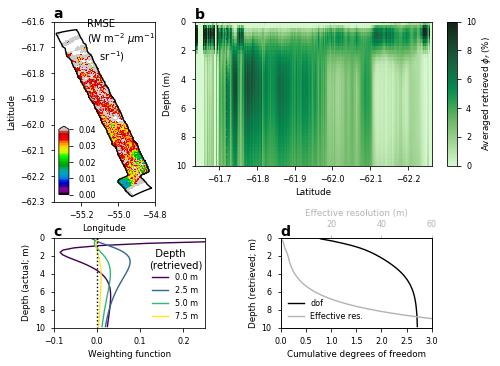

In [40]:
cmap = plt.cm.viridis
fs = 10;

plt.figure(figsize=(7,5))
ax1 = plt.axes([.1,.45,.2,.5]); 
ax2 = plt.axes([.38,.55,.47,.4]); 
ax3 = plt.axes([.1,.1,.3,.25]); 
ax4 = plt.axes([.55,.1,.3,.25]);
ax4b = ax4.twiny(); 
cax1 = plt.axes([.11,.47,.02,.19]); 
cax2 = plt.axes([.88,.55,.02,.4]);

im1 = ax1.contourf(loc_sm[:,:,0],loc_sm[:,:,1],dataset_sm_rmse*1000,levels=np.arange(0,0.041,.001),extend='max',cmap=plt.cm.nipy_spectral);
ax1.contour(loc_sm[:,:,0],loc_sm[:,:,1],flightpath,[0],colors='k',lw=1)

im2 = ax2.pcolor(np.nanmean(loc_sm[:,:,1],axis=1),np.arange(0,z_center[-1]+.25,.25),np.nanmean(dataset_sm_qI_profile,axis=1).T*100,vmin=0,vmax=10,cmap=cmocean.cm.algae);

inds = [np.argmin(np.abs(z_center-zz)) for zz in [0,2.5,5,7.5]]
for i in range(len(inds)):
    ax3.plot(AK[:,inds[i]],z_center,color=cmap(np.linspace(0,1,len(inds))[i]))
ax3.legend(['0.0 m','2.5 m','5.0 m','7.5 m'],loc='lower right',framealpha=0)
ax3.plot([0,0],[0,10],'k:')

l3, = ax4.plot(np.cumsum(np.diag(AK)),z_center,color='k')
l4, = ax4b.plot(.25/AK_max,z_center,color='0.7'); plt.ylim([10,0]); plt.xlim([0,50])
ax4b.legend([l3,l4],['dof','Effective res.'],loc='lower left',framealpha=0)

cbar1 = plt.colorbar(im1,cax=cax1,ticks=np.arange(0,0.041,.01))
cbar2 = plt.colorbar(im2,cax=cax2,label='Averaged retrieved $\phi_f$ (%)',ticks=np.arange(0,11,2));

ax1.set_ylabel('Latitude'); ax1.set_xlabel('Longitude'); ax1.set_xlim([-55.35,-54.8]); ax1.set_ylim([-62.3,-61.6]); ax1.set_xticks(np.arange(-55.2,-54.7,.2))
ax2.set_xlabel('Latitude'); ax2.set_ylabel('Depth (m)'); ax2.set_ylim([10,0]); ax2.set_xlim(np.mean(loc_sm[:,:,1],axis=1)[[0,-1]]);
ax3.set_ylabel('Depth (actual; m)'); ax3.set_xlabel('Weighting function'); ax3.set_ylim([10,0]); ax3.set_xlim([-.1,.25])
ax4.set_xlabel('Cumulative degrees of freedom'); ax4.set_ylabel('Depth (retrieved; m)'); ax4.set_ylim([10,0]); ax4.set_xlim([0,3]); #ax4.set_xticks(np.arange(0,3,.5))
ax4b.set_xlabel('Effective resolution (m)',color='0.7'); ax4b.tick_params(color='0.7', labelcolor='0.7'); ax4b.set_xlim([0,60]); ax4b.set_xticks(np.arange(20,61,20))

ax1.text(.33,.78,'RMSE\n(W m$^{-2}$ $\mu$m$^{-1}$\n    sr$^{-1}$)',fontsize=fs,transform=ax1.transAxes)
ax3.text(.63,.66,'  Depth\n(retrieved)',fontsize=fs,transform=ax3.transAxes)

ax1.text(0,1.02,'a',fontsize=fontsize,fontweight='bold',transform=ax1.transAxes)
ax2.text(0,1.02,'b',fontsize=fontsize,fontweight='bold',transform=ax2.transAxes)
ax3.text(0,1.02,'c',fontsize=fontsize,fontweight='bold',transform=ax3.transAxes)
ax4.text(0,1.02,'d',fontsize=fontsize,fontweight='bold',transform=ax4.transAxes)

plt.savefig('Fig4_edit',dpi=300)

In [283]:
print(np.nanmean(loc_sm[[177,285],:,1],axis=1))
print(np.nanmean(loc_sm[[511,608],:,1],axis=1))

[-61.80049979 -61.89992863]
[-62.11009653 -62.21026998]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


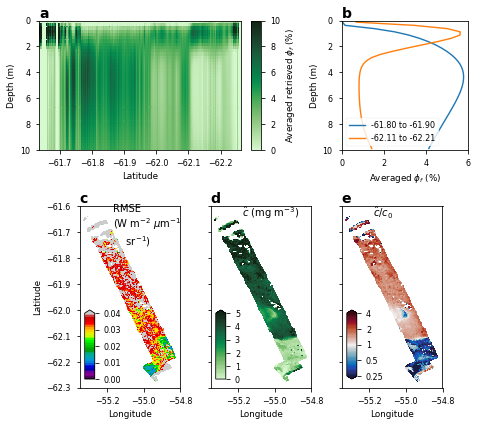

In [288]:
cmap = plt.cm.viridis
fs = 10;

plt.figure(figsize=(7,6))
ax1 = plt.axes([.1,.65,.4,.3])
ax2 = plt.axes([.7,.65,.25,.3])
ax3 = plt.axes([.18,.1,.2,.42]);
ax4 = plt.axes([.44,.1,.2,.42]);
ax5 = plt.axes([.7,.1,.2,.42]);

cax1 = plt.axes([.52,.65,.02,.3])
cax3 = plt.axes([.19,.12,.02,.16])
cax4 = plt.axes([.45,.12,.02,.16])
cax5 = plt.axes([.71,.12,.02,.16])

im1 = ax1.pcolor(np.nanmean(loc_sm[:,:,1],axis=1),np.arange(0,z_center[-1]+.25,.25),np.nanmean(dataset_sm_qI_profile,axis=1).T*100,vmin=0,vmax=10,cmap=cmocean.cm.algae);
ax2.plot(np.nanmean(dataset_sm_qI_profile[177:285],axis=(0,1))*100,z_center,label='%.2f to %.2f'%(np.nanmean(loc_sm[177,:,1]),np.nanmean(loc_sm[285,:,1])))
ax2.plot(np.nanmean(dataset_sm_qI_profile[511:608],axis=(0,1))*100,z_center,label='%.2f to %.2f'%(np.nanmean(loc_sm[511,:,1]),np.nanmean(loc_sm[608,:,1])))
im3 = ax3.contourf(loc_sm[:,:,0],loc_sm[:,:,1],dataset_sm_rmse*1000,levels=np.arange(0,0.041,.001),extend='max',cmap=plt.cm.nipy_spectral);
im4 = ax4.contourf(loc_sm[:,:,0],loc_sm[:,:,1],dataset_sm_retrieved_chl,levels=np.arange(0,5.1,.1),extend='max',cmap=cmocean.cm.algae);
im5 = ax5.contourf(loc_sm[:,:,0],loc_sm[:,:,1],np.log10(dataset_sm_retrieved_chl/chl_sm),vmin=np.log10(.25), vmax=np.log10(4),levels=np.linspace(np.log10(.25),np.log10(4),50),extend='both',cmap=cmocean.cm.balance);

cbar1 = plt.colorbar(im1,cax=cax1,label='Averaged retrieved $\phi_f$ (%)',ticks=np.arange(0,11,2));
cbar3 = plt.colorbar(im3,cax=cax3,ticks=np.arange(0,0.041,.01))
cbar4 = plt.colorbar(im4,cax=cax4,ticks=np.arange(0,5.1,1))
cbar5 = plt.colorbar(im5,cax=cax5,ticks=np.log10([.25,.5,1,2,4]))
cbar5.set_ticklabels([.25,.5,1,2,4])

ax1.set_xlabel('Latitude'); ax1.set_ylabel('Depth (m)'); ax1.set_ylim([10,0]); ax1.set_xlim(np.mean(loc_sm[:,:,1],axis=1)[[0,-1]]);
ax2.set_xlabel('Averaged $\phi_f$ (%)'); ax2.set_ylabel('Depth (m)'); ax2.set_ylim([10,0]); ax2.set_xlim([0,6]); ax2.legend(loc='lower left')
ax3.set_ylabel('Latitude'); ax3.set_xlabel('Longitude'); ax3.set_xlim([-55.35,-54.8]); ax3.set_ylim([-62.3,-61.6]); ax3.set_xticks(np.arange(-55.2,-54.7,.2))
ax4.set_xlabel('Longitude'); ax4.set_xlim([-55.35,-54.8]); ax4.set_ylim([-62.3,-61.6]); ax4.set_xticks(np.arange(-55.2,-54.7,.2)); ax4.set_yticklabels([])
ax5.set_xlabel('Longitude'); ax5.set_xlim([-55.35,-54.8]); ax5.set_ylim([-62.3,-61.6]); ax5.set_xticks(np.arange(-55.2,-54.7,.2)); ax5.set_yticklabels([])

ax3.text(.33,.78,'RMSE\n(W m$^{-2}$ $\mu$m$^{-1}$\n    sr$^{-1}$)',fontsize=fs,transform=ax3.transAxes)
ax4.text(.31,.94,'$\hat{c}$ (mg m$^{-3}$)',fontsize=fs,transform=ax4.transAxes)
ax5.text(.31,.94,'$\hat{c}/c_0$',fontsize=fs,transform=ax5.transAxes)

ax1.text(0,1.02,'a',fontsize=fontsize,fontweight='bold',transform=ax1.transAxes)
ax2.text(0,1.02,'b',fontsize=fontsize,fontweight='bold',transform=ax2.transAxes)
ax3.text(0,1.02,'c',fontsize=fontsize,fontweight='bold',transform=ax3.transAxes)
ax4.text(0,1.02,'d',fontsize=fontsize,fontweight='bold',transform=ax4.transAxes)
ax5.text(0,1.02,'e',fontsize=fontsize,fontweight='bold',transform=ax5.transAxes)

plt.savefig('Fig4_edit',dpi=300)